<a href="https://colab.research.google.com/github/kenanEkici/COVID19-fake-tweet-detection-XAI/blob/main/Masterproef_HCI_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Kenan Ekici

# Introduction

<img src="https://www.memesmonkey.com/images/memesmonkey/d0/d017cba8767eba32edc7e43e6132d4a7.jpeg" />

# Imports

In [ ]:
#lime
!pip install lime -q
import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular

# for hydrating tweet ids
!pip install twarc -q

#utils
import os
import re
import json
import random
from datetime import datetime
from shutil import copyfile
import string
from string import ascii_letters
from collections import Counter, defaultdict

#math, data
import numpy as np
from numpy import inf
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import math
from textblob import TextBlob

#plots, image
import cv2
from skimage import io
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ml, nlp
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import make_pipeline

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

     |████████████████████████████████| 276kB 5.9MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Collecting raw data

A dataset of Tweets and their corresponding label (fake news or not) is required in order to build a supervised machine learning classifier to detect Tweets that contain misinformation. As a result, the following sources have been collected which consist of Tweet ID's (a reference to the Tweet on Twitter). The second and third source contain news article contents and website claims with their corresponding label. These will be an additional source to mine language features that are deemed important to classify fake news, beyond the features learned from Tweets. The Tweets can contain any kind of information. However, we are mostly interested into claims and news articles regardless how it is presented, that is, objectively or subjectively. Recall that due to privacy reasons, the Tweets below have been compressed to the ID of the Tweet and the ID of the users. This ultimately means that we will need a third party library in order to collect the actual information that the ID's point to. In the context of Twitter, this is also referred to as, "rehydrating" the Tweets. In the next section, we will present a library for that purpose. Finally, we will also train a supervised classifier for detecting social bots as these were discussed to be an important source of fake news. The last proposed source contains ID's of users that were labeled as either social bot or real accounts. These must also be rehydrated using the third party library.   

Source #1: https://github.com/firojalam/COVID-19-tweets-for-check-worthiness (Downloaded 06-10-2020)

Source #2: https://github.com/cuilimeng/CoAID (Downloaded 06-10-2020)

Source #3: https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv (Downloaded 06-10-2020)

Source #4: http://mib.projects.iit.cnr.it/dataset.html

In [ ]:
# for convenience, we will download a bundle of all the sources from a Google drive endpoint
# if this endpoint does not work, please contact the author

# we dump all the raw files to the folder RawData
!rm -rf RawData
!rm -rf Junk
!rm -rf Classified
!gdown https://drive.google.com/uc?id=122tFro5g5u08M_DwLwYn5wDfHOR8BT48
!unzip RawData.zip
!rm RawData.zip

Downloading...
From: https://drive.google.com/uc?id=122tFro5g5u08M_DwLwYn5wDfHOR8BT48
To: /content/RawData.zip
8.51MB [00:00, 74.9MB/s]
Archive:  RawData.zip
   creating: RawData/
  inflating: RawData/covid19_infodemic_english_data.tsv  
  inflating: RawData/corona_fake.csv  
  inflating: RawData/cresci_fake_users.txt  
   creating: RawData/07-01-2020/
  inflating: RawData/07-01-2020/ClaimFakeCOVID-19.csv  
  inflating: RawData/07-01-2020/NewsFakeCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimFakeCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/NewsFakeCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19.csv  
  inflati

## Source 1

The first source contains COVID-19 related Tweets that have been extensively labeled by a community. The Tweets are categorized based on the answers they provide to the following questions:

- Q1: "Does the tweet contain a verifiable factual claim?"
- Q2: "To what extent does the tweet appear to contain false information?"
- Q3: "Will the tweet’s claim have an effect on or be of interest to the general public?"
- Q4: "To what extent does the tweet appear to be harmful to society, person(s), company(s) or product(s)?"
- Q5: "Do you think that a professional fact-checker should verify the claim in the tweet?"
- Q6: "Is the tweet harmful for society and why?"
- Q7: "Do you think that this tweet should get the attention of a government entity?"

The provided TSV file is loaded as a dataframe. The dataframe contains the ID and textual content of the Tweet as well as columnn that each represent one of the questions above. The columns (questions) have a variety of possible answers (refer to Github source 1). Thus, it is possible to filter out some of the Tweets from the dataframe that are not relevant. For the final misclassification Tweet dataset, we add every Tweet which contains the following answers: "yes" to question 1, "yes, probably or definitely contains false info" to question 2, and "yes, either urgent or not urgent" to question 5. 

In [ ]:
df = pd.read_csv('RawData/covid19_infodemic_english_data.tsv', sep='\t')

In [ ]:
df_1 = df.loc[df['q1_label'] == 'yes']
df_1 = df.loc[(df['q2_label'] == '4_yes_probably_contains_false_info') | (df['q2_label'] == '5_yes_definitely_contains_false_info')]
df_1 = df.loc[(df['q5_label'] == 'yes_not_urgent') | (df['q5_label'] == 'yes_very_urgent')]
df_1.head()

tweet_id  ...                    q7_label
4   1241447017945223169  ...          no_not_interesting
11  1240676575168921600  ...       yes_blame_authorities
13  1240768501452697600  ...       yes_blame_authorities
15  1241337295606657033  ...  yes_discusses_action_taken
19  1241057919128526856  ...  yes_discusses_action_taken

[5 rows x 9 columns]

In [ ]:
# We only need the Tweet ID's
tweets_fake_1 = df_1['tweet_id']

## Source 2

https://arxiv.org/pdf/2006.00885.pdf

The second source CoAID contains both factual and misleading COVID-19 claims from websites and news articles. It also contains Tweets that make COVID-19 related claims or share related news. The factual articles and claims have collected from reliable media outlets and websites such as WHO's official website.The fake news articles have been collected from fact-checking websites such as PolitiFact. The Tweets were queried based whether they contained news titles of misleading or factual news and thus labeled accordingly. The paper also presents important insights on the CoAID dataset such as the frequency of the hashtags used in both fake and real news and a list common claims. For our dataset, we collect only the labeled claims, news articles, and Tweets (both news and claims) but not the user replies. 

In [ ]:
def read_content_from_folder(dir_name): 
  fake_claims = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19.csv'))['title']
  fake_claims = pd.DataFrame({'content':fake_claims})
  fake_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19_tweets.csv'))['tweet_id']
  fake_news =  pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19.csv'))[['title', 'content']]
  fake_news['content'] = fake_news['title'].replace(np.nan, '', regex=True) + ' ' + fake_news['content'].replace(np.nan, '', regex=True)
  fake_news = pd.DataFrame({'content':fake_news['content']})
  fake_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19_tweets.csv'))['tweet_id']

  real_claims = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19.csv'))['title']
  real_claims = pd.DataFrame({'content':real_claims})
  real_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19_tweets.csv'))['tweet_id']
  real_news =  pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19.csv'))[['title', 'content']]
  real_news['content'] = real_news['title'].replace(np.nan, '', regex=True) + ' ' + real_news['content'].replace(np.nan, '', regex=True)
  real_news = pd.DataFrame({'content':real_news['content']})
  real_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19_tweets.csv'))['tweet_id']

  return [fake_claims, fake_claims_tweets, fake_news, fake_news_tweets, real_claims, real_claims_tweets, real_news, real_news_tweets]

l1 = read_content_from_folder('RawData/05-01-2020/')
l2 = read_content_from_folder('RawData/07-01-2020/')

all_dfs = []

# merging two lists, reset index
for i, dataframe in enumerate(l1):
  all_dfs.append(dataframe.append(l2[i], ignore_index=True))

fc, fct, fn, fnt, rc, rct, rn, rnt = all_dfs

In [ ]:
# join previous fake claims tweet id's with new collectd id's
fct = tweets_fake_1.append(fct, ignore_index=True)

## Source 3

The third source contains around 500 factual and 500 misleading news articles collected by the author of https://towardsdatascience.com/covid-fake-news-detection-with-a-very-simple-logistic-regression-34c63502e33b, senior data scientist Susan Li. We collect both the content and the title of the articles and combine them in one column. 

In [ ]:
# code from: https://github.com/susanli2016/NLP-with-Python/blob/master/Fake_News_LogReg.ipynb
df = pd.read_csv('RawData/corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

df['title_text'] = df['title'] + ' ' + df['text']
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text
    
df['title_text'] = df['title_text'].apply(preprocessor)
df['label'].value_counts()

TRUE    586
FAKE    578
Name: label, dtype: int64

In [ ]:
df_t = pd.DataFrame({'content':df.loc[df['label']=='TRUE']['title_text']})
df_f = pd.DataFrame({'content':df.loc[df['label']=='FAKE']['title_text']})

In [ ]:
fn = fn.append(df_f, ignore_index=True)
rn = rn.append(df_t, ignore_index=True)

## Source 4

The last dataset contains a list of Twitter user ID's of both bots and real accounts which have been labeled through CrowdFlower, a crowdsourcing platform. This data will be necessary to train the social bot classifier in a later section. Due to privacy reasons, the dataset may not be distributed. You can request the dataset from the authors or use another source. For the latter case, please replace the file paths below with the path of a text file containing a list of Twitter user ID's. 

In [ ]:
bot_user_id = pd.read_csv("RawData/cresci_fake_users.txt", header=None)
real_user_id = pd.read_csv("RawData/cresci_real_users.txt", header=None)

## Raw dataframes

We now have collected all of the necessary data. Although the claims and articles are raw strings, the Tweets are ID's (due to privacy reasons) and thus must be fetched explictely from the Twitter API. In the next section, we will use Twarc to fetch the Twitter level data.   

In [ ]:
dataframes = [("fake_claims", fc), ("fake_claims_tweets", fct), ("fake_news", fn), ("fake_news_tweets", fnt), 
              ("real_claims", rc), ("real_claims_tweets", rct), ("real_news", rn), ("real_news_tweets", rnt),
              ("bot_users", bot_user_id), ("real_users", real_user_id)]

[print(i[0], len(i[1])) for i in dataframes]
print()

fake_claims 28
fake_claims_tweets 644
fake_news 1416
fake_news_tweets 10416
real_claims 338
real_claims_tweets 7795
real_news 3303
real_news_tweets 141548
bot_users 3455
real_users 3474



# Rehydrating tweet IDS

We will use Twarc to rehydrate the Twitter ID's that we collected in the previous section. Twarc will rehydrate the ID's and collect the Twitter level data. This includes the Tweet and the data of the user that posted the Tweet. We will rehydrate both the Tweet ID's and the user ID's that we have collected in the previous section. In order to use Twarc, you will need a Twitter developer key and access token which you can request from the Twitter developer API.  


In [ ]:
# you can ignore this variable
# this will always be False if you are not the author of this notebook
author = True

# for temps files
!mkdir Junk

if not author:
  tweets_fake = fnt.append(fct, ignore_index=True)
  tweets_true = rnt.append(rct, ignore_index=True)

  # we combine all found tweet IDS
  print(len(tweets_fake), len(tweets_true))

  with open("Junk/tweets_fake.txt", "w") as f:
      for line in tweets_fake:
          f.write(str(line)+"\n") 

  with open("Junk/tweets_real.txt", "w") as f:
      for line in tweets_true:
          f.write(str(line)+"\n") 

  copyfile("RawData/cresci_fake_users.txt", "Junk/cresci_fake_users.txt")
  copyfile("RawData/cresci_real_users.txt", "Junk/cresci_real_users.txt")

  # Need a Twitter dev account and keys
  !twarc configure

  !mkdir Classified

  !twarc hydrate Junk/tweets_fake.txt > Classified/tweets_fake.jsonl
  !twarc hydrate Junk/tweets_real.txt > Classified/tweets_real.jsonl
  !twarc users Junk/cresci_real_users.txt > Classified/real_users.jsonl
  !twarc users Junk/cresci_fake_users.txt > Classified/fake_users.jsonl
else:
  # only the author can retrieve the prepopulated data from a personal Google drive folder
  !gdown https://drive.google.com/uc?id=1eSc4OM4-AOh0E829ShObkHk_NpiGGlL-
  !unzip Classified.zip
  !rm Classified.zip

def read_json(filename):
  tweets = []
  with open(filename) as f:
    for line in f:
      tweets.append(json.loads(line))
  return tweets  

Downloading...
From: https://drive.google.com/uc?id=1eSc4OM4-AOh0E829ShObkHk_NpiGGlL-
To: /content/Classified.zip
68.1MB [00:00, 120MB/s] 
Archive:  Classified.zip
   creating: Classified/
  inflating: Classified/tweets_real.jsonl  
  inflating: Classified/fake_users.jsonl  
  inflating: Classified/real_users.jsonl  
  inflating: Classified/tweets_fake.jsonl  


As you can verify below, after collecting the Tweets from the API, the amount of entries are a lot less than the actual raw data. This is because some of the Tweets (and users) may have been deleted and thus resulted into empty entries.

In [ ]:
# these contain both Tweet data and user data
tweets_fake_ = read_json('Classified/tweets_fake.jsonl')
tweets_real_ = read_json('Classified/tweets_real.jsonl')

# these only contain user data
users_fake_ = read_json('Classified/fake_users.jsonl')
users_real_ = read_json('Classified/real_users.jsonl')

#sanity check
print(len(tweets_fake_))
print(len(tweets_real_))
print(len(users_fake_))
print(len(users_real_))

10165
142761
2804
2892


# Feature selection and mining

Now that we have collected the Tweets and users in JSON format, we can determine which columns we want to keep for the final dataset. After all, the API returns a large set of columns and features. Some of these feature are not necessary for building the classifiers. We have defined two helper functions to convert the JSON files of both Tweets and users to a Pandas dataframe. This will be easier to work with when doing analysis. We will also simultaneously filter the columns that are redundant. 

In [ ]:
tweet_columns = ["id", "source", "full_text", "retweet_count", "favorite_count", "possibly_sensitive"]
user_columns = ["id", "name", "screen_name", "has_extended_profile", "location", "description", "url", "protected", "followers_count", "friends_count", "listed_count", "created_at", "favourites_count", "geo_enabled", "verified", "statuses_count", "contributors_enabled", "is_translator", "is_translation_enabled", "profile_image_url", "profile_use_background_image", "default_profile", "default_profile_image", ]

# this function will be used to convert the json files that contain
# both the tweet level and user level data to a Pandas dataframe
def json_to_dataframe(json, amount):
  tweets = []
  users = []
  for i, t in enumerate(json):
    tweet_row = []
    user_row = []
    for _, tc in enumerate(tweet_columns):
      if (tc == "possibly_sensitive"):
        if "possibly_sensitive" in t:
          tweet_row.append(t["possibly_sensitive"])
        else:
          tweet_row.append(False)
      else:
        tweet_row.append(t[tc])    
    for _, tu in enumerate(user_columns):
      user_row.append(t['user'][tu])
    tweets.append(tweet_row)
    users.append(user_row)
  df_t = pd.DataFrame(data= tweets, columns=tweet_columns)
  df_u = pd.DataFrame(data=users, columns=user_columns)

  return df_t[0:amount], df_u[0:amount]

# this function will be used to convert only the json files
# that contain user level data to a Pandas dataframe
def user_json_to_dataframe(json):
  users = []
  for i, u in enumerate(json):
    user_row = []
    for _, tu in enumerate(user_columns):
      user_row.append(u[tu])
    users.append(user_row)
  df_u = pd.DataFrame(data=users, columns=user_columns)
  return df_u

The literature and related work proposes a variety of techniques to improve classification of anomalous behavior such as social bots or fake news. Data mining is such a technique in which new knowledge is inferred from existing data. We will use this technique to generate new columns from the existing ones that were retreived from the API. An example of these features are username length, likes and age ratio or the ratio of friends to followers. The following functions will be used to mine such features. 

In [ ]:
def preprocess_tweet(mined_data, keep_all=True):
  def add_amount_features(col_name, char):
    mined_data[col_name] = 0
    for i, s in enumerate(mined_data['full_text']):
      n_q = 0
      for k in s:
        if (k == char):
          n_q +=1
      mined_data[col_name].loc[i] = n_q

  add_amount_features('n_question', '?')
  add_amount_features('n_exclaim', '!')
  add_amount_features('n_hash', '#')

  mined_data['n_uppercase'] = mined_data['full_text'].str.findall(r'[A-Z]').str.len()
  mined_data['length'] = mined_data['full_text'].str.len()
  
  mined_data['has_link'] = False
  for i, s in enumerate(mined_data['full_text']):
    mined_data['has_link'].loc[i] = ('t.co' in s) or ('http' in s)

  return mined_data

def preprocess_users(mined_data, keep_all=False):

  #return mined_data['ratio'].replace([np.inf, -np.inf], np.nan).fillna(1)
  
  mined_data['bio_length'] = mined_data['description'].apply(len)
  mined_data['username_length'] = mined_data['screen_name'].apply(len)
  mined_data['name_length'] = mined_data['name'].apply(len)
  date_format = "%a %b %d %H:%M:%S +%f %Y" 
  mined_data['age_account_days'] = 0
  for i, r in enumerate(mined_data['created_at']):
    a = datetime.now()
    b = datetime.strptime(r, date_format)
    mined_data['age_account_days'].iloc[i] = (a - b).days
  
  mined_data['friends_count'] = mined_data['friends_count'].replace([0],1)
  mined_data['followers_friends_ratio'] = (mined_data['followers_count'] / mined_data['friends_count'])
  mined_data['age_account_days'] = mined_data['age_account_days'].replace([0],1)
  mined_data['likes_age_ratio'] = (mined_data['favourites_count'] / mined_data['age_account_days'])
  mined_data['verified'] = mined_data['verified'].astype(int)
  mined_data['has_location'] = mined_data['location'] != ''
  mined_data['has_location'] = mined_data['has_location'].astype(int)
  mined_data['default_profile_image'] = mined_data['default_profile_image'].astype(int)
  mined_data['has_extended_profile'] = mined_data['has_extended_profile'].astype(int)
  mined_data['default_profile'] = mined_data['default_profile'].astype(int)
  mined_data['protected'] = mined_data['protected'].astype(int)
 
  return mined_data

During the retrieval of the raw data, it was rather evident that there was more data of normal behavior (factual news), then there is of anomalous behavior (fake news). This is a known problem in supervised classification of anomalous behavior which is due the fact that anomalies occur less often. Below, we make sure that we maintain a balanced dataset for training. 

In [ ]:
# these contain fake/real news and claims of Twitter users 
# as well as the users that posted them
amount = 10000
tweets_fake, tweets_fake_users = json_to_dataframe(tweets_fake_, amount)
tweets_real, tweets_real_users = json_to_dataframe(tweets_real_, amount)
tweets_fake = preprocess_tweet(tweets_fake)
tweets_real = preprocess_tweet(tweets_real)

# we preprocess the previous users and mine relevant features
tweets_fake_users = preprocess_users(tweets_fake_users)
tweets_real_users = preprocess_users(tweets_real_users)

# these will be used to train the social bot detector 
bots = preprocess_users(user_json_to_dataframe(users_fake_))
non_bots = preprocess_users(user_json_to_dataframe(users_real_))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Finalized dataset

We have now collected all the required data and mined the features that are necessary for further analysis and the development of the supervised classifiers. However, before we develop the classifiers, we must do analyze the dataset in order to gain an insight on both the features and their correlation with the target labels that we aim to predict. This process will help to determine which features are useful and which are not.

**The final dataset that we will continue using consists of:**



In [ ]:
fake_news_articles = fn
real_news_articles = rn
print(len(fake_news_articles), "Fake and", len(real_news_articles), "real news articles (text)")

fake_claims = fc
real_claims = rc
print(len(fake_claims), "fake and", len(real_claims), "real website claims (text)")

print(len(tweets_fake), "fake and", len(tweets_real), "real news and claims (tweets)")

print("The corresponding", len(tweets_fake_users)+len(tweets_real_users) ,"users that posted these fake real claims and news (users) - version for analysis")

#print("The corresponding", len(tweets_fake_users_study)+len(tweets_real_users_study) ,"users that posted these fake real claims and news (users) - version for user study")
 
print(len(bots), "bots and", len(non_bots), "real users (users)")

1416 Fake and 3303 real news articles (text)
28 fake and 338 real website claims (text)
10000 fake and 10000 real news and claims (tweets)
The corresponding 20000 users that posted these fake real claims and news (users) - version for analysis
2804 bots and 2892 real users (users)


# Data analysis

In this section, we will analyze the dataset we have collected previously. The purpose of analysis is to find features that correlate with misinformation. We will use these features in order to develop a misinformation classifier in a later section. We will explore all the features that were deemed important by literature. These include features that were mined in the data mining step. We divide this section into both misinformation and social bot. In the latter, we will analyze whether some users have specific features that correlate with them being a social bot. As we know from literature, social bots can be used to spread misinformation and can thus be an important indicator in the detection of misinformation.   

## Misinformation

We must analyze the data to find features that are highly correlated with the target label (fake or not fake news). In this section, we will analyze the Twitter data which consists of both the Tweet level data and user level data. In order to do this, we explicitly label fake news (and claims) with the number <b>one</b>, and the factual news (and claims) with <b>zero</b>.  

In [ ]:
# 20K users 
tweets_users = (tweets_fake_users.append(tweets_real_users, ignore_index=True))
# 20K tweets
tweets = (tweets_fake.append(tweets_real, ignore_index= True))

# 20K corresponding labels
y = np.concatenate((np.ones(len(tweets_fake)), np.zeros(len(tweets_real))))
tweets['label'] = y
tweets_users['label'] = y 

columns_merged = pd.concat([tweets, tweets_users], axis=1)

### Social impact

The first analysis will be that of social impact as each Tweet contains both the amount of retweets and favorites. Below, we plot the social impact that each Tweet has on a scatterplot. Hereby, we can confirm that fake news is spread and favorited a lot more than real news! When we inspect the scatterplot more closely (second figure), we can see that the odds of a Tweet being fake increases when it has more than 100 favorites and 100 retweets.

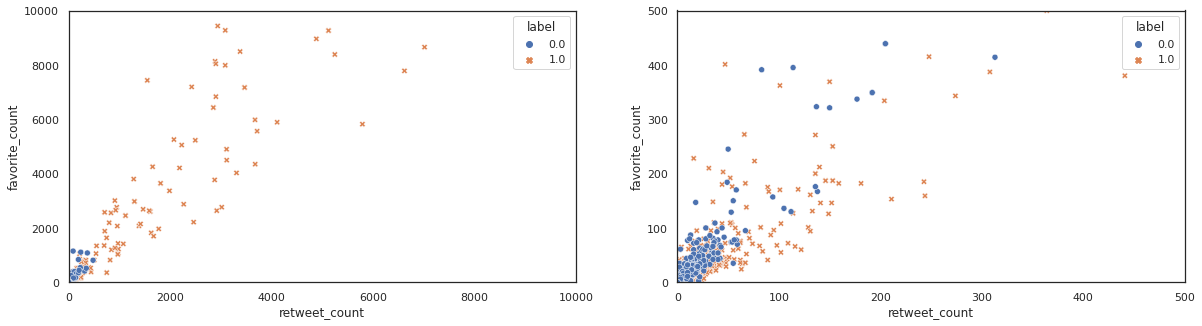

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
sns.scatterplot(data=tweets, x="retweet_count", y="favorite_count", style="label", hue="label", ax=axs[0])
axs[0].set_xlim(0,10000)
axs[0].set_ylim(0,10000)
ax = sns.scatterplot(data=tweets, x="retweet_count", y="favorite_count", style="label", hue="label", ax=axs[1])
axs[1].set_xlim(0,500)
axs[1].set_ylim(0,500)
print()

### Tweet text

We also consider linguistic features which might be strong indicators for fake news. These features are:
- length of the tweet
- number of question marks, exclamation marks, uppercased characters, number of hashtags
- whether the contains a URL
- whether the Tweet is subjective or objective
- marked by Twitter as sensitive

We can see that the plots below do not show notable differences between the linguistic features of fake and real news Tweets except for the last plot indicating that fake news might include more uppercases than baseline behavior.  

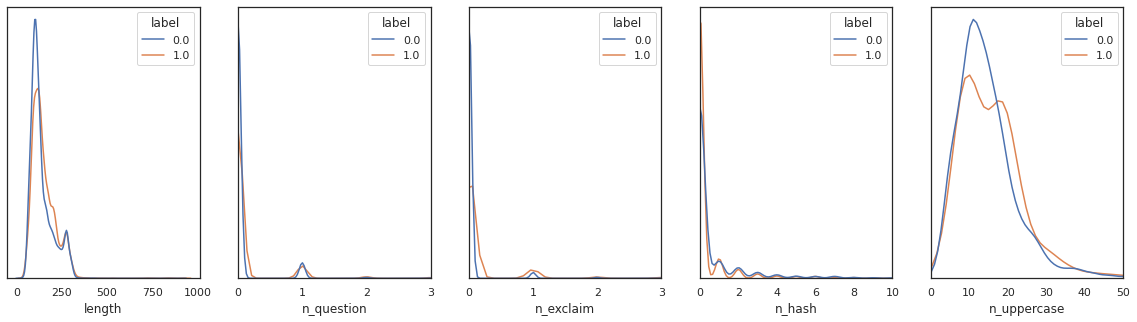

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(20,5))

for ax in axs:
  ax.get_yaxis().set_visible(False)

sns.kdeplot(data=tweets, x="length", hue="label", ax=axs[0])
sns.kdeplot(data=tweets, x="n_question", hue="label" ,ax=axs[1])
axs[1].set_xlim(0,3)
sns.kdeplot(data=tweets, x="n_exclaim", hue="label", ax=axs[2])
axs[2].set_xlim(0,3)
sns.kdeplot(data=tweets, x="n_hash", hue="label", ax=axs[3])
axs[3].set_xlim(0,10)
sns.kdeplot(data=tweets, x="n_uppercase", hue="label", ax=axs[4])
axs[4].set_xlim(0,50)
print()

In [ ]:
#https://medium.com/pew-research-center-decoded/detecting-subjectivity-and-tone-with-automated-text-analysis-tools-5f0e662224b8
def textblob_adj(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    adj_list = []
    adv_list = []
    adj_tag_list = ['JJ','JJR','JJS']
    adv_tag_list = ['RB','RBR','RBS']
    for (a, b) in blobed.tags:
        if b in adj_tag_list:
           adj_list.append(a)
        elif b in adv_tag_list:
           adv_list.append(a)
        else:
            pass
    return adj_list, adv_list, counts['JJ']+counts['JJR']+counts['JJS'], counts['RB']+counts['RBR']+counts['RBS']
    
#https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7
 
# TODO: clean the tweets
tweets['subjective'] = 0
tweets['adj_c'] = 0
tweets['adv_c'] = 0
for i, s in enumerate(tweets['full_text']):
  adj, adv, adj_c, adv_c = textblob_adj(s)
  tweets['adj_c'].loc[i] = adj_c
  tweets['adv_c'].loc[i] = adv_c
  if (adv_c >= 3):
    tweets['subjective'].loc[i] = 1
print(tweets['subjective'].value_counts())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0    18977
1     1023
Name: subjective, dtype: int64


By calculating the F1 score of both the boolean features and the ground truth labels, we can find out whether the features accurately represent the ground truth. We can see below that the "has_link" feature has a high F1 score meaning that this feature is very useful to distinguish misinformation. The latter features are less useful and will ignored in the training of the classifier.   

In [ ]:
print(f1_score(tweets["has_link"], y))
print(f1_score(tweets["subjective"], y))
print(f1_score(tweets["possibly_sensitive"],y))

0.6348720800889878
0.10850040823732196
0.06461974492205952


### User characteristics

Below, we can see that the feature "ratio" is a good indicator of whether a Tweet will more likely to be misinformation. The ratio is the amount of followers a user has, divided by the amount of people following. For users that post misinformation, this ratio will be high meaning that they are likely to follow a lot more people that follow them back. This behavior is also very typical for social bots.

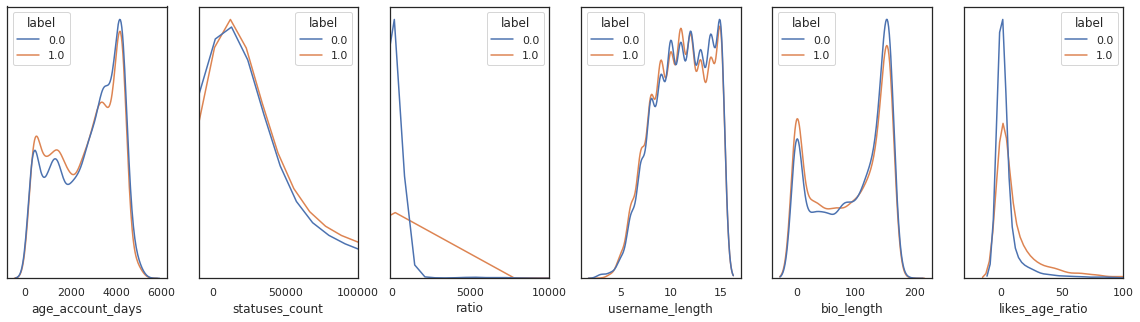

In [ ]:
fig, axs = plt.subplots(ncols=6, figsize=(20,5))

for ax in axs:
  ax.get_yaxis().set_visible(False)
  
sns.kdeplot(data=tweets_users, x="age_account_days", hue="label", ax= axs[0])
sns.kdeplot(data=tweets_users, x="statuses_count", hue="label", ax= axs[1])
axs[1].set_xlim(-10000,100000)
sns.kdeplot(data=tweets_users, x="ratio", hue="label", ax= axs[2])
axs[2].set_xlim(-100,10000)
sns.kdeplot(data=tweets_users, x="username_length", hue="label", ax=axs[3])
sns.kdeplot(data=tweets_users, x="bio_length", hue="label",  ax=axs[4])
sns.kdeplot(data=tweets_users, x="likes_age_ratio", hue="label", ax=axs[5])
axs[5].set_xlim(-30,100)
print()

Interestingly, "has_location" is a useful feature to determine whether someone is likely to spread misinformation.

In [ ]:
print(f1_score(y,tweets_users['default_profile_image'].astype(int)))
print(f1_score(y, tweets_users['protected'].astype(int)))
print(f1_score(y, tweets_users['verified'].astype(int)))
print(f1_score(y, tweets_users['has_location'].astype(int)))

0.09533431300514326
0.0
0.051016566265060244
0.5715919767964378


### Feature correlation

In order to avoid cross-corelation of features - which can negatively affect classifiers - we compute the feature correlation matrix. As expected, both retweet count and favorite count are positively correlated.

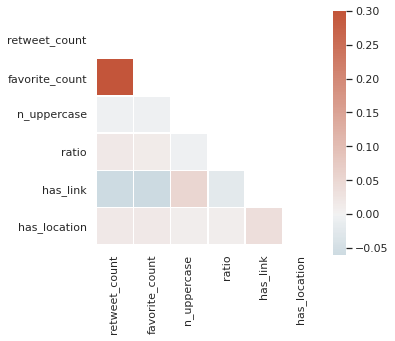

In [ ]:
sns.set_theme(style="white")
# Generate a large random dataset
d = columns_merged[["retweet_count", "favorite_count", "n_uppercase", "ratio", "has_link", "has_location"]]
# Compute the correlation matrix
corr = d.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  

### Opinion spam and duplication

In this subsection, we will find out how many Tweets are unique and how many have been retweeted or duplicated. The purpose of misinformation is to spread quickly in order to manipulate public opinion. One way this can be achieved is when a lot of users retweet one specific news article or claim. 

A naive way to do this is to listwise compare each Tweet content by cosine similarity. A high cosine similarity will usually indicate whether two Tweets contain similar content. We use cosine similarity rather than hashing because the content of the Tweet is likely to change when it has been retweeted. That is, new information will be added. By lowering the cosine similarity threshold, we can relax the similarity distance. However, if the threshold is too low (or too high), two Tweets might be dissimilar and the results will not be accurate. 

A hypothesis that we can try to confirm here is that misinformation Tweets will spread "more". That is, we should see less total amount of unique misinformation Tweets compared to "real" news.   

In [ ]:
#https://gist.github.com/ahmetalsan/06596e3f2ea3182e185a

# compute the cosine similarity 
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

# turn Tweet content into a vector
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

# compute the cosine similarity of two Tweets
def get_result(text1, text2):
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine_result = get_cosine(vector1, vector2)
    return cosine_result


By default we ignore this computation because it takes a long time to run. You can enable it by changing the first condition to "True". 

The following algorithm will cluster Tweets that are similar in a dictionary. The length of the resulting dictionary of clusters will determine roughly how many unique Tweets each dataset (fake news and real news) is composed of. If we see that fake news Tweets contain less unique tweets than real news, then we can confirm the proposed hypothesis. 

The cosine similarity will have a significant effect on the clustering in that there will be a tradeoff between the cosine similarity and accuracy. If the cosine similarity is too high, then we will have smaller and more clusters and thus "many" uniques. This will be an overestimate of the ground truth. If the cosine similarity is too low, then we will have less clusters but larger in size. In that case, we will have an underestimate of amount of unique Tweets. Much like choosing the amount of K's in KNN algorithm, it is hard to define a good threshold. Because the algorithm is relatively slow, it is impossible to run many trials and pick a threshold accordingly. By trial and error, we pick a threshold of 0.9.   

In [ ]:
# tradeoff # clusters <-> # uniques found
# higher cosine similarity -> smaller and more clusters -> more uniques than ground truth
# lower cosing similarity -> larger and less clusters -> less uniques than ground truth
# what is a good cosine similarity threshold? We can only know if we inspect everything -> infeasible with 10K tweets
if False:

  cos_threshold = 0.9
  tweets_ = []

  for j,r in tweets_fake.iterrows():
    tweets_.append(r['full_text'])

  book = defaultdict()
  for i, a in enumerate(tweets_):
    if (a != ""):
      print(i)
      to_join = []
      for j, b in enumerate(tweets_):
        if (i != j):
          if (b != ""):
            if (get_result(a,b) >= cos_threshold):
              to_join.append(j)
              tweets_[j] = ""
      if (len(to_join) > 0):
        book[i] = to_join
      else:
        book[i] = [i]
      tweets_[i] = ""

  c = 0
  for i, k in enumerate(book):
    if len(book[k]) > 0:
      c+=1

  print("# unique tweets before clusting: ", len(tweets_fake))
  print("# unique tweets after clusting: ", c)
  print("Reduction of: ", int(((len(tweets_fake)-c)/len(tweets_fake))*100), "%")
  print("Realistic? Use same cosine threshold for real tweets and compare reduction")
  print("Hypothesis = fake news spreads more than real news")
  print("Hypothesis is not true for this dataset. Both have similar reduction rates for a given cosine similarity.")

0
2
3
10
12
15
28
29
30
31
32
37
41
45
46
48
50
52
55
60
62
66
69
70
72
74
77
78
79
80
81
83
84
85
86
87
89
90
91
94
96
97
98
99
102
103
106
107
108
109
113
115
116
118
120
123
124
125
126
127
128
130
132
136
137
138
139
140
141
142
144
145
146
149
150
151
152
153
154
155
156
157
160
161
164
165
166
172
176
177
179
181
182
184
186
188
191
192
193
213
216
220
228
229
240
241
242
243
246
251
252
253
254
256
257
258
259
260
263
264
266
268
273
274
277
279
287
288
289
290
291
292
295
299
302
303
304
307
309
310
314
317
318
321
325
326
327
328
330
337
341
344
345
346
347
351
353
359
364
366
367
368
369
370
371
372
373
374
376
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
455
458
459
462
463
464
465
466
469
470
471
472
473
474
475
476
477
478

Next, we can see which misinformation Tweets in the dataset have been shared the most.  

In [ ]:
max_l = 0
max_i = 0
for i, k in book.items():
  if (len(k))> max_l:
    max_l = len(k)
    max_i = i

tweets_fake['full_text'].loc[max_i]

'Irrefutable: The coronavirus was engineered by scientists in a lab using well documented genetic engineering vectors that leave behind a “fingerprint” - https://t.co/hKLY6ZS4x4'

Only half of the Tweets for both the "fake" and "real" news/claims were unique. The nature of Twitter (retweet) allows some Tweets to spread more effectively than others. This is actually very important because when a certain Tweet is labeled as misinformation, every other Tweet that is similar can also be labeled similarly. In this way, a large of Tweets can be labeled very efficiently. Especially when you know that millions of Tweets can possibly stem from one misinformed news or claim. 

### Hashtag wordclouds

Although word clouds are not desired way to visualize qualitiative data (they are confusing at best), they suffice for testing purposes. Here, we will visualize which hashtags are prominent in Tweets containing either "fake" and "real" news/claims. 

In [ ]:
# extract hashtags
tweets_fake["hashtag"] = tweets_fake["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))
tweets_real["hashtag"] = tweets_real["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))

In [ ]:
# we will remove content that will most likely appear in both classifications
too_obv = ["corona", "covid", "virus", "http", '#corona', "#covid", "#virus"]
obv = [ "people", "health", "new", "disease", 
       "pandemic", "–"]

# preprocessing helper
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

# preprocessing helper
def clean(content):
  words = content.split()
  result  = [word.lower() for word in words if word.lower().strip() not in obv and not word.lower().strip().startswith(tuple(too_obv))]
  content = ' '.join(result)
  content = remove_punct(content)
  return content

In [ ]:
# https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

def frame_to_words(df, fake):
  words = ""
  for i, k in df.iterrows():
    for hash in k["hashtag"]:
      words += hash + " "
  return clean(words)

words = frame_to_words(tweets_fake, True)
w1 = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)

words = frame_to_words(tweets_real, False)
w2 = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)


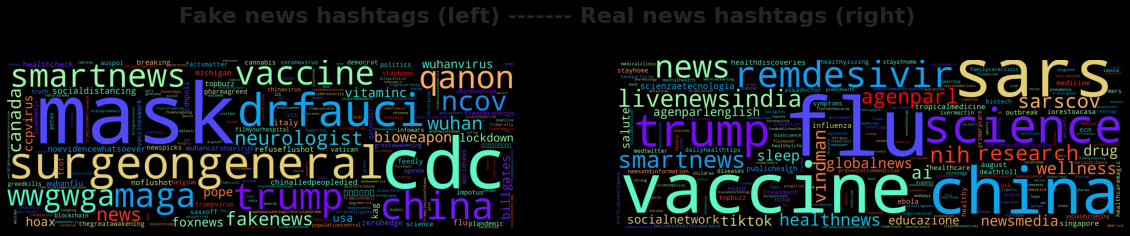

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
fig.suptitle('Fake news hashtags (left)          Real news hashtags (right)', fontsize=22, fontweight='bold')
axs[0].imshow(w1)
axs[0].axis("off")
axs[1].imshow(w2)
axs[1].axis("off")
fig.set_facecolor("black")
print()

## Social bot

We mentioned previously that social bots are notorious for spreading fake news. In other words, they are not a reliable source of information and can be identified by a set of features and behaviors. In this subsection, we explore these features.

### User characteristics

In [ ]:
# we label bots with 1 and real users with 0
non_bots['label'] = 0
bots['label'] = 1
users = non_bots.append(bots, ignore_index=True)

Below, we can compare the distribution of the features related to bots and real accounts. The feature "likes_age_ratio" shows that bot accounts are likely to have a low ratio while real accounts have a higher ratio. A high ratio indicates a balanced amount of user activity over a amount of time since the user has created their account. A low ratio means that the user did not have significant amount of likes, even if their account was made a long time ago. This seems reasonable when we consider that most bot accounts are made for very specific yet malicious purposes (inflating follow counts, spreading Tweets,...). 

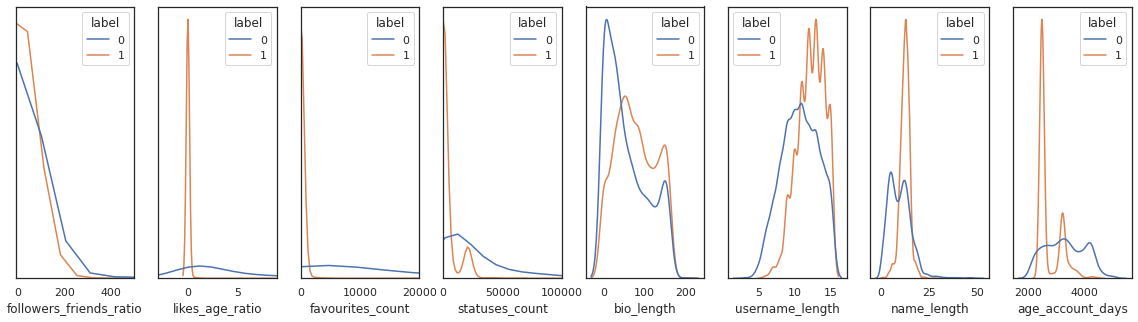

In [ ]:
fig, axs = plt.subplots(ncols=8, figsize=(20,5))

for ax in axs:
  ax.get_yaxis().set_visible(False)

sns.kdeplot(data=users, x="followers_friends_ratio", hue="label", ax= axs[0])
axs[0].set_xlim(-10,500)
sns.kdeplot(data=users, x="likes_age_ratio", hue="label", ax= axs[1])
axs[1].set_xlim(-3,9)
sns.kdeplot(data=users, x="favourites_count", hue="label", ax= axs[2])
axs[2].set_xlim(0,20000)
sns.kdeplot(data=users, x="statuses_count", hue="label", ax= axs[3])
axs[3].set_xlim(-100,100000)
sns.kdeplot(data=users, x="bio_length", hue="label", ax= axs[4])
sns.kdeplot(data=users, x="username_length", hue="label", ax= axs[5])
sns.kdeplot(data=users, x="name_length", hue="label", ax= axs[6])
sns.kdeplot(data=users, x="age_account_days", hue="label", ax= axs[7])
print()

### Feature correlation

We can see that the favourites count and likes age ratio are positively correlated. This is normal since the latter was computed based on the former.  

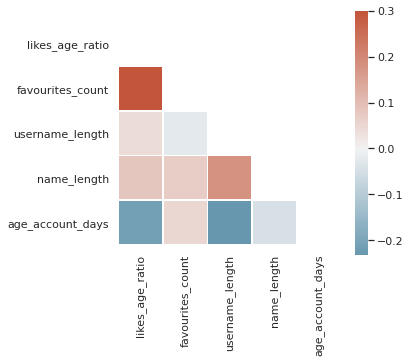

In [ ]:
sns.set_theme(style="white")
# Generate a large random dataset
d = columns_merged[["likes_age_ratio", "favourites_count", "username_length", "name_length", "age_account_days"]]
# Compute the correlation matrix
corr = d.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  

# Building a TFIDF misinformation classifier

In this section, we will train a classifier on TFIDF features. TFIDF is the product of the term frequence TF and inverse document frequency IDF. 

For term T:

- TF = number of occurence term T in document / total number of terms in document
- IDF = total number of documents / number of documents with term T 
- TFIDF = TF * IDF

The IDF is necessary to scale down the TFIDF score of words that occur in many documents. These are typically stop words that carry less important when classifying text. 

TODO: build TF only hashtag classifier?

## Preparing documents

First, we have to collect the content of the different sources (news, claims, Tweets) of our dataset into one array of documents.  

In [122]:
def collect_from_sources(news, claims, tweets):
  content = []

  for i, cont in news.iterrows():
    content.append(clean(cont['content']))

  for i, cont in claims.iterrows():
    content.append(clean(cont['content']))

  for i, cont in tweets.iterrows():
    content.append(clean(cont['full_text']))
  
  return content

# array of documents
fake = collect_from_sources(fake_news_articles, fake_claims, tweets_fake)
real = collect_from_sources(real_news_articles, real_claims, tweets_real)

# and their respective label
y = np.concatenate((np.ones(len(fake), dtype=np.uint16), np.zeros(len(real), dtype=np.uint16)))

In [ ]:
data = []

for f in fake:
  data.append(f)

real_ = random.sample(real, len(fake))
for r in real_:
  data.append(r)

y_ = y[0:len(data)]

# sanity check
print("We have", len(data), "amount of documents in our array and", len(y_), "amount of corresponding labels")

We have 22888 amount of documents in our array and 22888 amount of corresponding labels


## Stemming + TFIDF features

In order to train the classifer with the TFIDF features, we must extract the features from the documents. We can use the TfidfVectorizer that will convert each document into a vector of features (terms). Below, we have chosen for a maximum of 1000 features. The vectorizer will pick the top 1000 features with the highest TF score. The documents will be converted into a vector of size 1000 where each entry (term) corresponds with the TFIDF score of that term. We also allow 2-grams, that is, two words that are used in combination. A stemmer is used to remove certain affixes from words. For example: "owned" becomes "own" and "flying" becomes "fly". The vectorizer also removes English stop words. 


In [136]:
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf = TfidfVectorizer(stop_words='english',
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        max_features=1000,
                        ngram_range=(1,2))
X = tfidf.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

In [137]:
 features = tfidf.get_feature_names()
 len(features)

1000

## Feature visualization

We can visualize the TFIDF features. One way to do that is with wordclouds. 

In [126]:
def plot_cloud(words, label):
  
  if (label == "Fake"):
    !wget -P Junk "https://techcentral.co.za/wp-content/uploads/2019/05/donald-trump-2156-1120.jpg" -q
    mask = np.array(Image.open('Junk/donald-trump-2156-1120.jpg'))
  else:
    !wget -P Junk "https://static01.nyt.com/images/2014/08/10/magazine/10wmt/10wmt-superJumbo-v4.jpg" -q
    mask = np.array(Image.open('Junk/10wmt-superJumbo-v4.jpg'))
  
  return WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS, mask=mask).generate(words)


def plot_important_tfidf_features(matrix, label, feature_tfidf_threshold):

  f = np.zeros(len(features))

  for feature_vector in enumerate(matrix.todense()): 
    vector = np.array(feature_vector[1]).flatten()
    result = np.where(vector>=feature_tfidf_threshold)
    for i in result[0]:
      f[i] += 1

  words = ""
  for i, k in enumerate(f):
    if (k != 0):
      for _ in range(0,int(k)):
        words += " " + features[i]
  return plot_cloud(words, label)

w1 = plot_important_tfidf_features(X[:len(fake)], "Fake", 0.5)
w2 = plot_important_tfidf_features(X[len(fake):], "Real", 0.5)

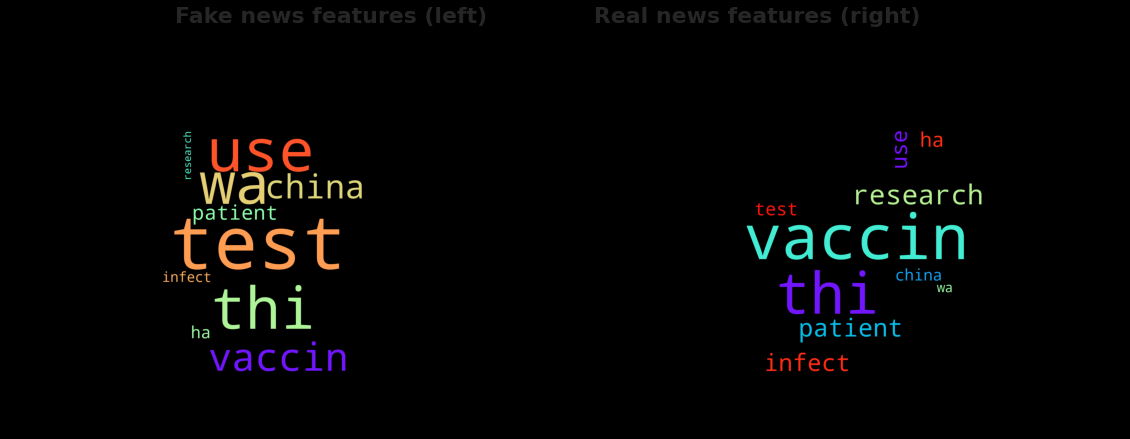

In [127]:
fig, axs = plt.subplots(ncols=2, figsize=(20,7))
fig.suptitle('Fake news features (left)              Real news features (right)', fontsize=22, fontweight='bold')

axs[0].imshow(w1)
axs[0].axis("off")
axs[1].imshow(w2)
axs[1].axis("off")
fig.set_facecolor("black")
print()

## Alternative visualizations

As you can see above, wordclouds are not a proper way to visualize qualitative information. They are confusing and bloated. In this subsection, we will look for alternative ways to display the TFIDF features. The first alternative is a word cloud that is supposed to be more organized, clear and one where size makes sense. That is, smaller sizes have smaller TFIDF scores.   

In [128]:
#https://gist.github.com/StevenMaude/ea46edc315b0f94d03b9
def get_scores(vectorizer, tfidf_result):
  # http://stackoverflow.com/questions/16078015/
  scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_result.sum(axis=0)).ravel())
  sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
  sorted_scores = sorted_scores[0:20]
  a = [tup[0] for tup in sorted_scores]
  b = [tup[1] for tup in sorted_scores]
  a.reverse()
  b.reverse()
  return a, b 

score_fake = get_scores(tfidf, X[0:(int(len(y)/2))])
score_real= get_scores(tfidf, X[(int(len(y)/2)):])

IndexError: ignored

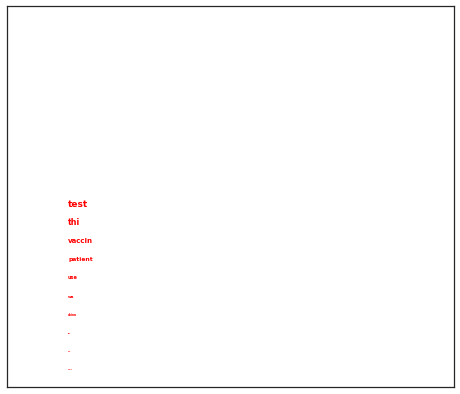

In [129]:
plt.figure(figsize=(8,7))
ax = sns.scatterplot(x=([0] * 20), y=np.arange(0,20),size=np.zeros(20), sizes=(0,0))
ax.set(xticks=[], yticks=[])
ax.legend().set_visible(False)

c=0
# label points on the p
for x, y in zip(([-0.04] * 20), np.arange(0,20)):
 plt.text(x= x, y=y, color="red",s = score_fake[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1

c=0
# label points on the p
for x, y in zip(([0.02] * 20), np.arange(0,20)):
 plt.text(x= x, y=y, color="green", s = score_real[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1


Next, we visualize the same features with a bar chart.  

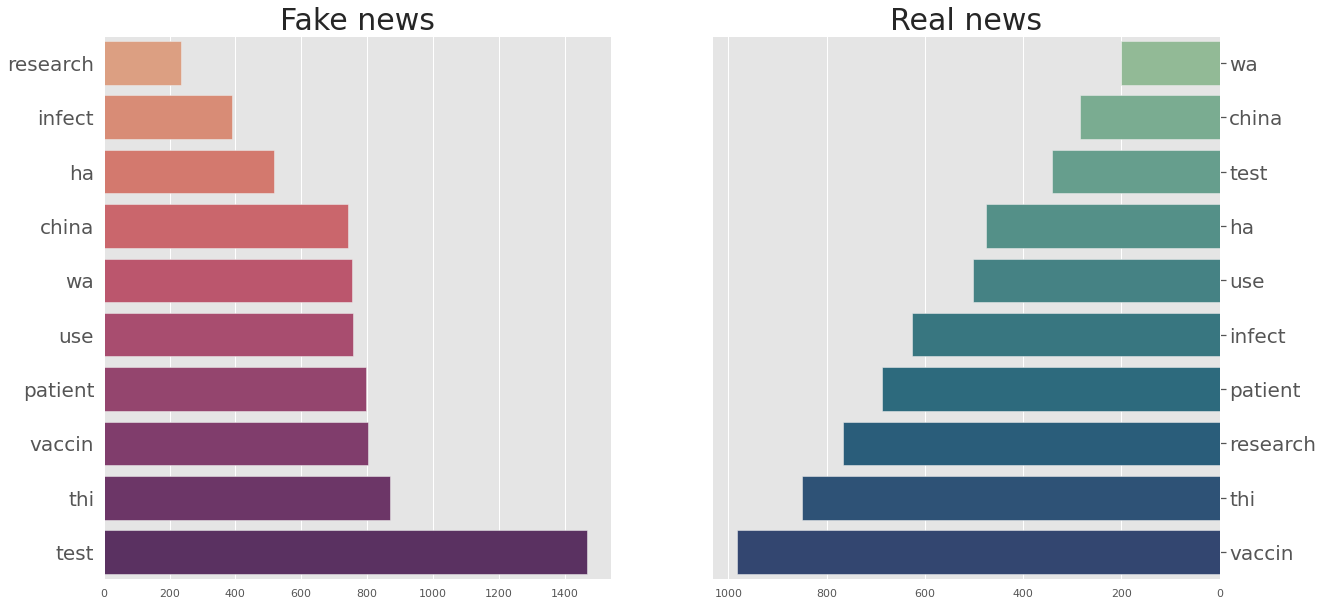

In [130]:
with plt.style.context('ggplot'):
  f = plt.figure(figsize=(20,10))
  ax0 = plt.subplot(121)
  sns.barplot(ax=ax0, y=score_fake[0], x=score_fake[1], palette="flare")
  plt.title('Fake news',fontsize=30)
  plt.yticks(fontsize=20)

  ax1 = plt.subplot(122)
  sns.barplot(ax=ax1, y=score_real[0], x=score_real[1], palette="crest")
  plt.title('Real news',fontsize=30)
  ax1.yaxis.set_ticks_position("right")
  plt.yticks(fontsize=20)
  ax1.invert_xaxis()

  plt.show()

We can also visualize the results of the vectorized documents in order to make more sense of the features and their occurences in the documents. From the following sparse matrix we can clearly see that the first half of the data (fake news) contains a consistent and bright clusters of features that co occur in documents. However, when we look at the documents in which a certain feature has a high TFIDF score, there is no consistency among documents. In the other half (real news), that is the case. We can clearly see a consistent occurence of words among all documents that have medium to high TFIDF scores.

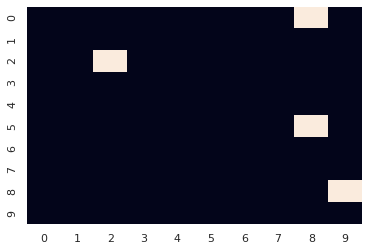

In [132]:
# TFIDF matrix 
# y axis = document = string of words and characters 
# x axis = vector of features with elements = tfidf score --> brighter = higher

sns.heatmap(X.todense(), vmin=0, vmax=1, cbar=False)

## Training white/black box model

We will train both a "white box" DecisionTree classifier and a "black box" RandomForest classifier. As you can see, the white box classifier performs significantly worse than the black box classifier.  

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y_, random_state=0, test_size=0.2, shuffle=True)

whitebox_fakenews = DecisionTreeClassifier(max_depth=3)
whitebox_fakenews.fit(X_train, y_train)
print("Whitebox DecisionTree F1 with depth 3: ", whitebox_fakenews.score(X_test, y_test))
blackbox_fakenews = RandomForestClassifier(n_estimators=20, max_depth=30).fit(X_train, y_train)
print("Blackbox RandomForest F1 score with 20 trees with depth 30: ", blackbox_fakenews.score(X_test, y_test))

Whitebox DecisionTree F1 with depth 3:  0.6439493228484054
Blackbox RandomForest F1 score with 20 trees with depth 30:  0.90956749672346


## Global understanding

We can visualize the "white box" classifier in order to understand how it works globally. Below, the nodes of the decision tree contain condition on which each node is split. That is, whether or not a specific term in the query has a TFIDF score smaller or equal to the presented value. Even though we refer to this classifier as white box, it does not mean that it is actually a white box model. For example, how would we explain this model to a non-expert user? We would have to explain what TFIDF means which in itself may confuse users and take a fair amount of time. Besides, we may not want to actually use nor explain this classifier in production mainly because of its low performance. If we decided to add more depth to the decision tree (to increase performance), it would become even harder to interpret the tree in a reasonable amount of time, even for experts. In that case, it might be easier to use the black box model and use model agnostic techniques to generate explanations for each prediction. We will use LIME in the next subsection to achieve this. That is, to generate local explanations.

White box model DecisionTree


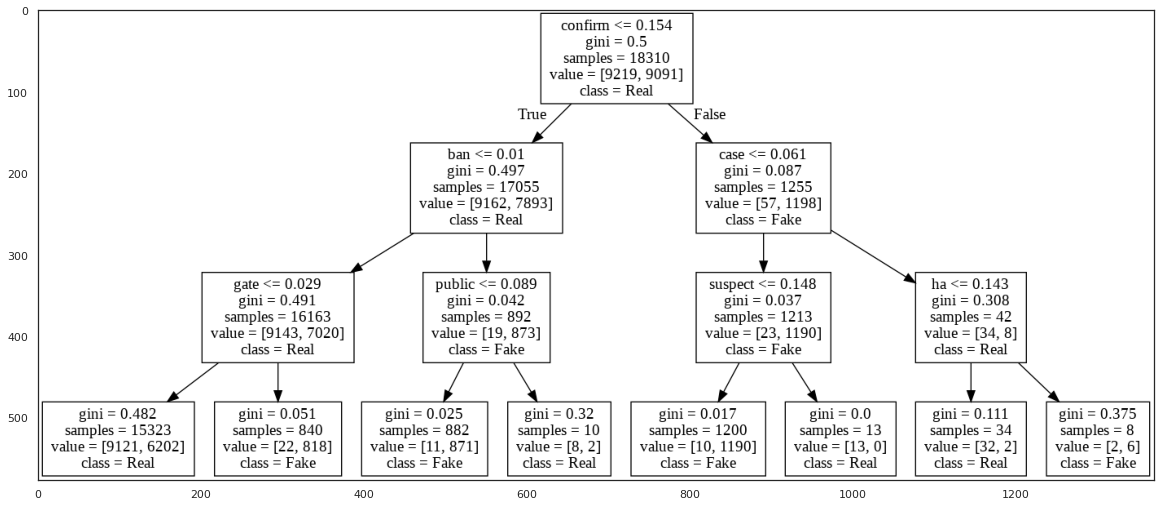

In [161]:
# Export as dot file
export_graphviz(model, out_file='tree.dot', 
                feature_names = features,
                class_names = ["Real", "Fake"])

! dot -Tpng tree.dot -o tree.png

img = cv2.imread('tree.png')
plt.figure(figsize = (20, 25))
print("White box model DecisionTree")
plt.imshow(img)

Let's try to solidify our understanding of the "white box" model above by considering an example sentence. We can follow the decision tree to see whether we can predict the label of the example sentence using the global "white box" model.

We start with the first node. The TFIDF score of "confirm" is not smaller than 0.154 (it's 0.43), thus we pick the right node. We pick the right node again because the TFIDF score of "case" is not smaller than 0.061. We stop on this node because the sentence does not contain the term in the node. The sentence then becomes labeled as "real". 

In [180]:
sentence = "there is a confirmed case of the virus in china"
v1 = tfidf.transform([clean(sentence)]).toarray()

def print_tfidf(vector):
  print("Features and TFIDF score: ")
  for i,k in enumerate(vector[0]):
    if k > 0:
      print("- ", features[i], k)

print_tfidf(v1)

print()
if (model.predict(v1)[0] == 1):
  print("Predicted as Fake")
else:
  print("Predicted as Real")

Features and TFIDF score: 
-  case 0.4377102652639404
-  china 0.4277732947535807
-  confirm 0.39369395494938797
-  confirm case 0.6858752086309481

Predicted as Real


## Performance visualisation

We can plot the confusion matrix to get a better sense of the performance of the black box model. 

Confusion matrix for LogisticRegression


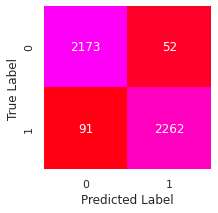

In [144]:
predictions = clf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3,3))
sns.heatmap(mat, annot=True, fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Local understanding (LIME)

We have trained a black box model previously and unlike the "white box" model, it has become much harder to explain the model globally. Thus, we can try to achieve a local understanding using LIME. This is a model agnostic technique that can help us to explain why a certain prediction was made by black box model. The explanation consists of a probability distribution, a list of the most important features (and their weights) that have contributed to the prediction as well as a heatmap of the text. 

There is a problem with this explanation. First of all, the heatmap gives us no explanation to why it exactly the terms are highlighted. All we can infer is that they somehow contributed to the sentence being classified as fake. Although we know that the TFIDF scores of the occuring terms led to the prediction, a non-expert user will never be able to understand this. We can still use the visualization as a guide, but we must come up with an alternative explanation to explain why these terms are indicative of real or fake news. 

In [179]:
text = "there is a confirmed case of the virus in china"
c = make_pipeline(tfidf, blackbox_fakenews)
class_names = ["TRUE", "FAKE"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(text, c.predict_proba, num_features = 10)
fig = exp.show_in_notebook()

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Building novel Twitter bot classifier

In this section, we will train a classifier to predict social bots. As mentioned previously, social bots are unreliable sources and are often deployed for malicious purposes. Detecting social bots can be a good way to indicate to users that they should not trust the Tweet. 

## Data preparation

In [209]:
non_bots['label'] = 0
bots['label'] = 1
data = non_bots.append(bots, ignore_index=True)
labels = data['label']
data = data[columns]
scaler = StandardScaler()

# we pick the columns that we have analyzed before
columns = ["likes_age_ratio", "favourites_count", "username_length", "name_length", "age_account_days"]
# we scale the numerical features 
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=columns )

X = data_scaled
y = labels

## Feature importance

We can visualize feature importance in order to discover the most important features that we shortlisted previously. We can see that "likes_age_ratio" and "favourites_count" are the most important features and will most contribute to the predictions.

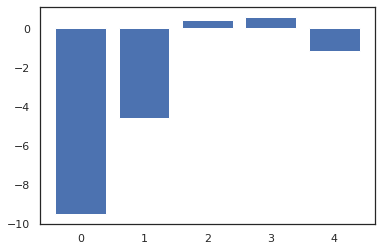

In [206]:
#https://machinelearningmastery.com/calculate-feature-importance-with-python/

# define dataset
def plot_fimp_log(X,y):
  model = LogisticRegression()
  # fit the model
  model.fit(X,y)
  # get importance
  importance = model.coef_[0]
  # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  plt.show()

plot_fimp_log(X, y)

## Training model

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)

# baseline classifier
majority = np.zeros(len(y_test))
accuracy_score(majority, y_test)

0.512280701754386

In [197]:
# define the model
bot_model = RandomForestClassifier(n_estimators=13)

# fit the model
bot_model.fit(X_train,y_train)
preds = bot_model.predict(X_test)
f1_score(preds, y_test)

0.9701897018970189

## Confusion matrix

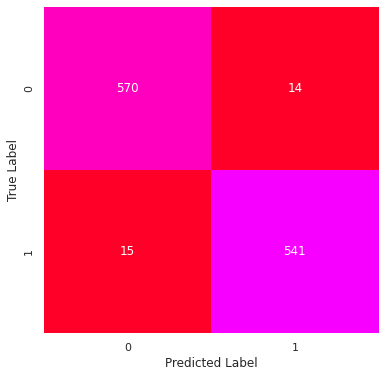

In [198]:
mat = confusion_matrix(y_test, preds_)
plt.figure(figsize=(6,6))
sns.heatmap(mat, annot=True,   fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Local understanding (LIME)

Similarly as before, we can use LIME to explain the predictions. However, the explanations do not seem to make much sense. A reason for this is because the features were scaled and no longer represent the actual values. 

In [210]:
i = 10
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns, mode='classification')
exp = explainer.explain_instance(X_test.iloc[i], bot_model.predict_proba)
print("Ground truth: ", y_test.iloc[i])
exp.show_in_notebook(show_table=True)

Ground truth:  0



# Export models and data 

For the user study, we will export 12 Tweets and split the Tweets in order to make sure that we have a balanced set. 

The final set will contain:
- 3 true positives 
- 3 true negatives
- 3 false positives
- 3 false negatives

## Dataframes for user study

In [ ]:
def df_to_json(dataframe, name):
  result = dataframe.to_json(orient="records")
  parsed = json.loads(result)
  with open('Junk/data_' +name+'.json', 'w') as out:
    json.dump(parsed, out)

In [ ]:
tweets_real.sort_values(by=["retweet_count", "favorite_count"], ascending=False)

In [ ]:
df_to_json(tweets_real.loc[[7728, 6227, 7553]], "real_tweets")

In [ ]:
df_to_json(tweets_real_users_study.loc[[7728, 6227, 7553]], "real_users")

In [ ]:
tweets_real_users_study.loc[[7728, 6227, 7553]]

In [ ]:
tweets_fake.sort_values(by=["retweet_count", "favorite_count"], ascending=False)[0:20]

In [ ]:
df_to_json(tweets_fake.loc[[9598, 9642, 9582]], "fake_tweets")

In [ ]:
df_to_json(tweets_fake_users_study.loc[[9598, 9642, 9582]], "fake_users")

In [ ]:
tweets_fake_users_study.loc[[9598, 9642, 9582]]